In [244]:
#Imports used throughout the notebook
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

import seaborn as sns
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F

#Moving computations to the gpu if available
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"Using {device} device")


Using cuda device


# Part 1

In your own words, answer the following questions:

**a: In your opinion, what were the most important turning points in the history of deep learning?**

I would start the list of turning points off with the Darthmouth summer workshop from 1956 as many would consider this the birth of deep learning as a distinct field. Following this, 1958 also marks an important year, as American psychologist Frank Rosenblatt develops the perceptron.

In 1989, LeCun, Y., Boser, B., Denker, J.S., et al. published the article Backpropagation Applied to Handwritten Zip Code Recognition. Neural Computation.
On a small aside, in 2006 Geoffrey Hinton coins the term "Deep Learning", and the paper "A fast learning algorithm for deep belief" was published. This might not be a major breakthrough per se, but I would still consider it rather important in the context.

While multiple points in time can be mentioned as important turning points in the history of deep learning, I will finish my answer with 2012, when Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton presented "AlexNet" and it wins the Imagenet Large Scale Visual Recognition Challenge. Furthermore, 2012 was also the year GPU trained networks started gaining traction, and the last decade, we can see the meteoric rise of Deep learning, and a lot of this is due to the technological advances in our GPU's.

**b: Explain the ADAM optimizer.**

Optimizers are methods used to find the parameters that minimize the loss function.

Adam is an extension of Stochastic gradient descent, and is a way to add Adaptive moment estimation to the optimizer. Furthermore, Adam is a combination of two gradient descent methods; Adaptive gradient algorithm (Adagrad), and Root Mean Square Propagation (RSMP).

To delve deeper into detail, lets have a look at the algorithm itself:
A key part of Adam is the fact that it obtains both the momentum, and 2nd moment of the gradient by using exponential weighted moving averages.
We define these as state variables v<sub>t</sub> and s<sub>t</sub>:<br>
v<sub>t</sub> &larr; &beta;<sub>1</sub>v<sub>t-1</sub>+(1-&beta;<sub>1</sub>)g<sub>t</sub><br>
s<sub>t</sub> &larr; &beta;<sub>2</sub>s<sub>t-1</sub>+(1-&beta;<sub>2</sub>)g<sup>2</sup><sub>t</sub>

Where &beta;<sub>1</sub> and &beta;<sub>2</sub> are nonnegative weighting parameters usually set to .9 and .999 respectively and to my understanding control the decay rates of the moving averages.<br>
Likewise, g<sub>t</sub> is the gradient of the loss with respect to the parameter at time step t.<br>
Finally,  it is important to understand that v<sub>t</sub> (the first moment) is an exponentially decaying average of past gradients, and s<sub>t</sub> of past squared gradients.

Personally, for simplicity, I try to just remember that Adam uses two moving averages instead of one, and one of those is of the 2nd moment of the gradient instead of the first.<br>
Before updating our weights, It is important to mention bias correction, as when the moving averages of v and s are initialized to 0, we have a bias towards 0 (especially if our &beta;'s are close to 1 aswell). Adam handles this by dividing with 1 - &beta; 1 and 2 respectively at the given timestep, as seen below:
$$ \hat{v}_t = \frac{v_t}{1 - \beta_1^t} $$
$$ \hat{s}_t = \frac{s_t}{1 - \beta_2^t} $$

As we now understand how to calculate the moving averages and correct for bias, we can see how adam updates the weights in a neural network:
$$ \theta_{t+1} = \theta_t - \frac{\alpha \hat{v}_t}{\sqrt{\hat{s}_t} + \epsilon} $$

As we can see, we calculate the weights for the next timestep, by taking our current weights and subtracting our bias-corrected 1<sup>st</sup> moment multiplied with the learning rate and divided with the square root of the 2<sup>nd</sup> moment added with &epsilon;. To my understanding &epsilon; is here to add numerical stability to the equation in cases such as division by 0 (prevents it)<br>
This seems to make sense, as the first moment of our gradient captures the mean of past gradients, it helps us understand which direction the gradients are going and can help us speed up convergence. So, if theyre positive, we want to reduce the weight of the given parameter, and if negative, we want to increase its weight. At the same time, the 2<sup>nd</sup> moment helps scale how much we change the weight of the parameter (together with the learning rate ofc.)<br><br>
**c: Assume data input is a single channel 30x40 pixel image. First layer is a convolutional layer with 5 filters, with kernel size 3x2, step size (1,1) and padding='valid'. What are the output dimensions?**<br>
Since we have no padding, we get:<br>
Output height is given as $$\frac{input_{height}-filter_{height}+1}{stride_{height}}$$
Output width is given as $$\frac{input_{width}-filter_{width}+1}{stride_{width}}$$
Thus we get:<br>
$$Output_{height} = \frac{30-3+1}{1} = 28$$
$$Output_{width} =  \frac{40-2+1}{1} = 39$$
Which means we get the following output dimensions (5, 28, 39) (channels,rows,columns), as we have 5 filters.


**d: Assuming ReLU activations and offsets, and that the last layer is softmax, how many parameters does this network have:** <br>
![](Neural_net_image.png)

The input layer has nothing to learn, it only provides the input to the network.<br>
From looking at the picture, I assume all layers are dense.<br>
Thus our calculations for the amount of parameters in each layer become quite simple:<br>
$$P_n = neurons_{n-1}*neurons_n+bias$$
Where $$P_n$$ is the parameters in the n<sup>th</sup> layer, neurons is the number of neurons in a given layer and bias is the number of biases in the given layer.<br>
Thus we get the total number of parameters to.<br>
$$P_t = (5*5+5)+(5*5+5)+(5*5+5)+(5*3+3)=108$$

**e: For a given minibatch, the targets are [1,4, 5, 8] and the network output is [0.1,4.4,0.2,10]. If the loss function is "torch.nn.HuberLoss(reduction='mean', delta=1.0)", what is the loss for this minibatch?**
The Huber loss is defined as:

$$
L_\delta(y, \hat{y}) = 
\begin{cases} 
0.5(y - \hat{y})^2 & \text{if } |y - \hat{y}| < \delta \\
\delta |y - \hat{y}| - 0.5 \delta^2 & \text{otherwise}
\end{cases}
$$
Where:
- y  is the true value.
- $\hat{y}$ is the predicted value.
- &delta; is a threshold.

The quadratic loss (the first part of the formula) is applied when the absolute difference between the true and predicted values is less than &delta;, and the linear loss (the second part of the formula) is applied otherwise. This makes Huber loss more robust to outliers compared to the mean squared error.<br>

To calculate the Huberloss for this minibatch, we calculate the Huberloss individually for each input and target, and then average across all losses.
Following the formula, we get:<br>

- $ \delta = 1.0 $
- Targets ($ y $): [1, 4, 5, 8]
- Network output ($ \hat{y} $): [0.1, 4.4, 0.2, 10]

**1. Calculation for $ y = 1 $ and $ \hat{y} = 0.1 $:**
   - $ |1 - 0.1| = 0.9 $
   - $ L_1 = 0.5 \times 0.9^2 = 0.405 $

**2. Calculation for $ y = 4 $ and $ \hat{y} = 4.4 $:**
   - $ |4 - 4.4| = 0.4 $
   - $ L_2 = 0.5 \times 0.4^2 = 0.08 $

**3. Calculation for $ y = 5 $ and $ \hat{y} = 0.2 $:**
   - $ |5 - 0.2| = 4.8 $
   - $ L_3 = 1 \times 4.8 - 0.5 = 4.3 $

**4. Calculation for $ y = 8 $ and $ \hat{y} = 10 $:**
   - $ |8 - 10| = 2 $
   - $ L_4 = 1 \times 2 - 0.5 = 1.5 $

**Average Huber loss:**
$$ \text{Huber loss} = \frac{L_1 + L_2 + L_3 + L_4}{4} = \frac{0.405 + 0.08 + 4.3 + 1.5}{4} = 1.57125 $$



# Part 2

In [135]:
#CustomImageDataset class, based on the tutorial from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#with some slight modifications to fit the dataset
#Modifications are generally commented in the code 
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        #make the indexing of the csv file to be the filename, and only use the filename and species columns, where species is the label
        self.img_labels = pd.read_csv(annotations_file, usecols=['filename', 'species']) #usecols added to only use the filename and species columns, could also have used drop
        self.img_dir = img_dir
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((520,520))]) #After running the first time, got dimensions errors, so added this to resize the images
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1]) #As the order in the csv is reversed, filename sits at index 1
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 0] #same as above, but species is at index 0
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


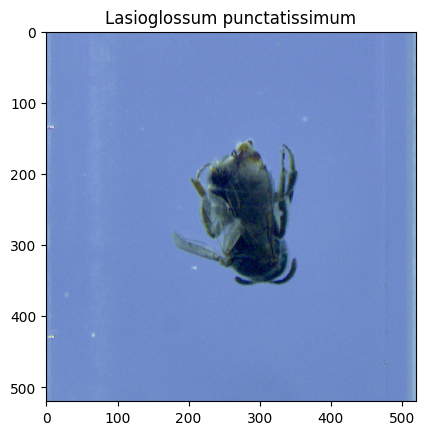

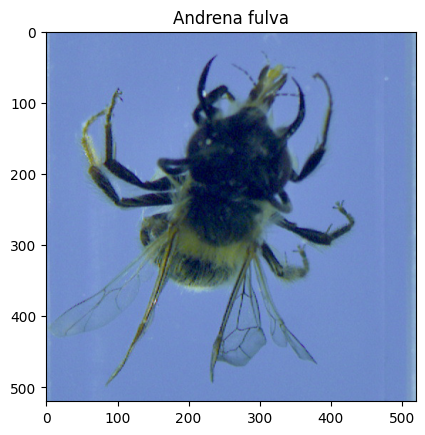

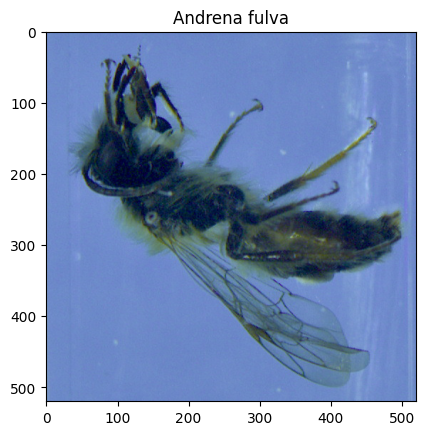

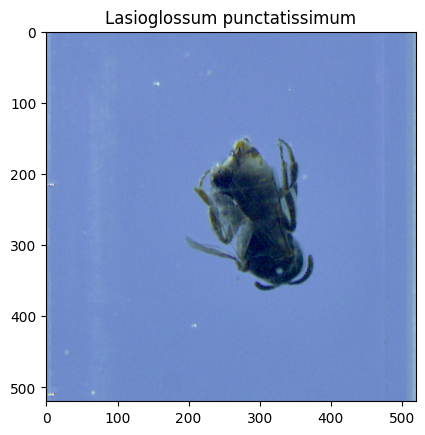

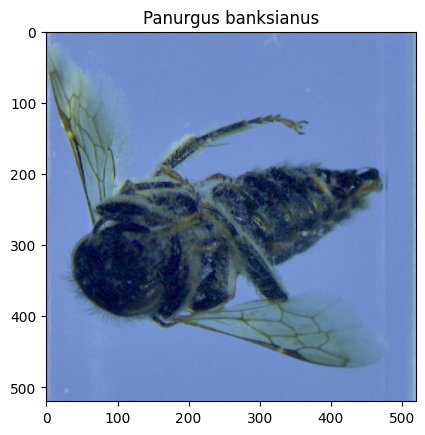

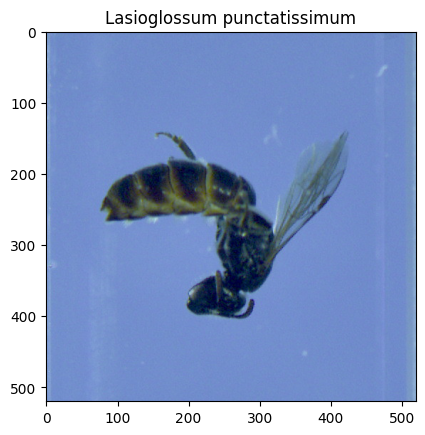

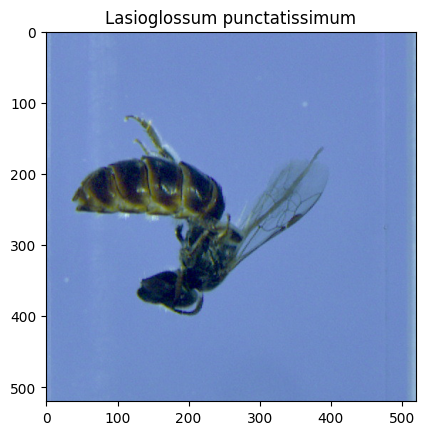

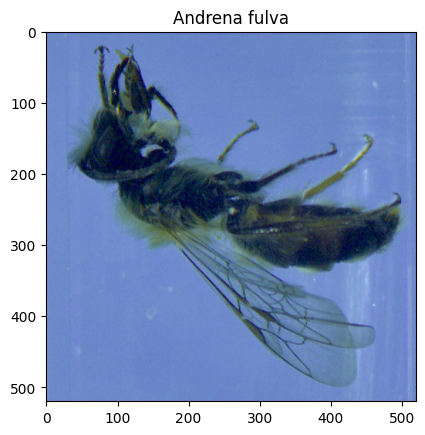

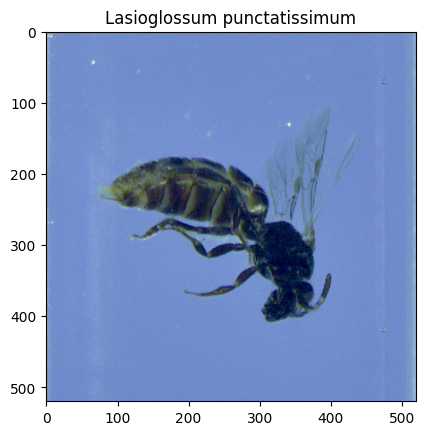

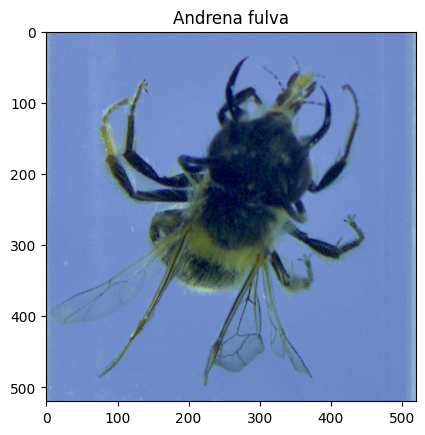

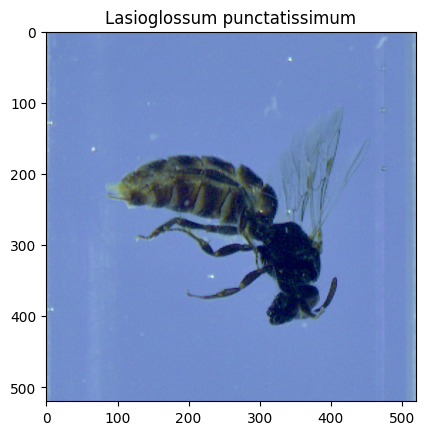

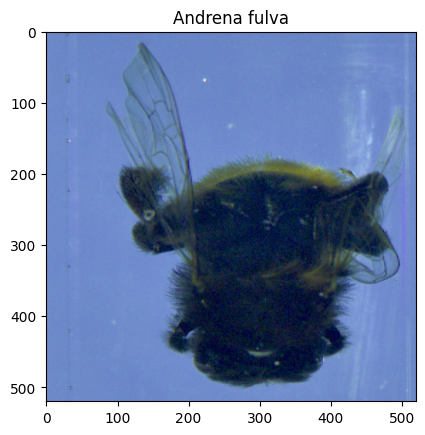

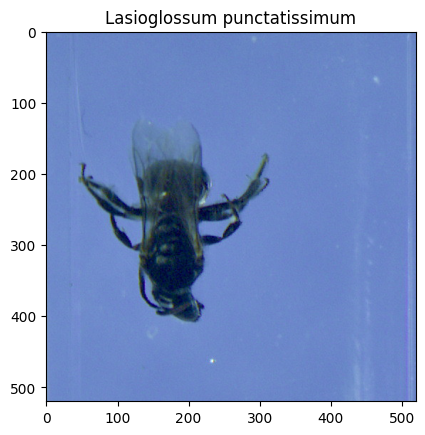

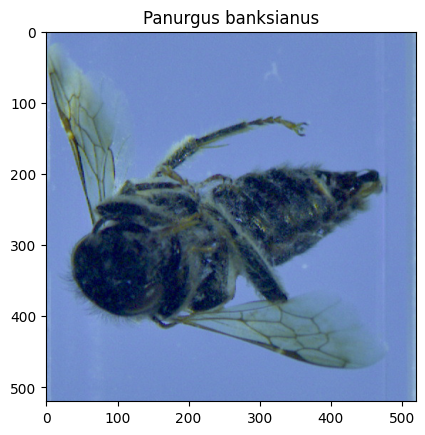

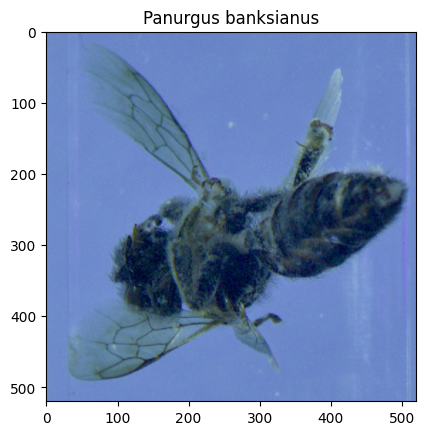

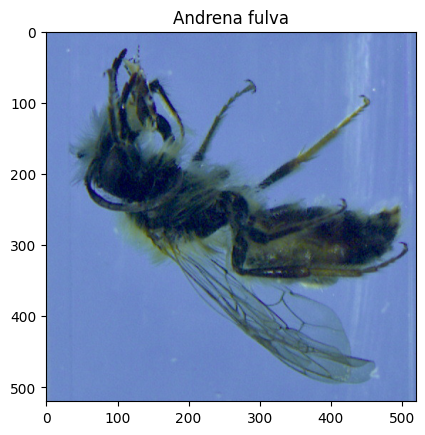

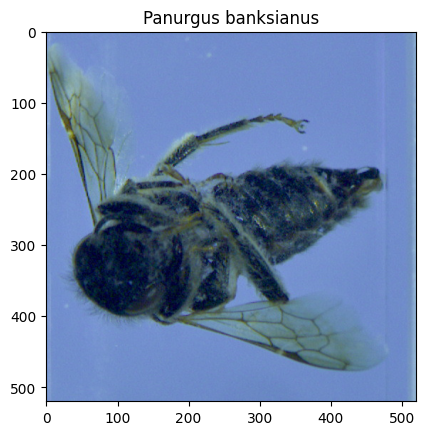

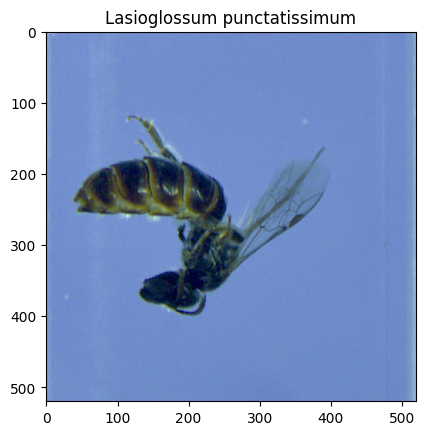

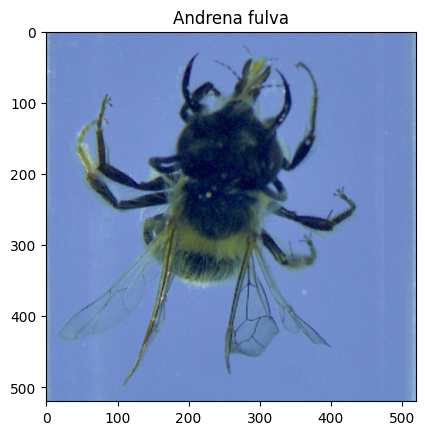

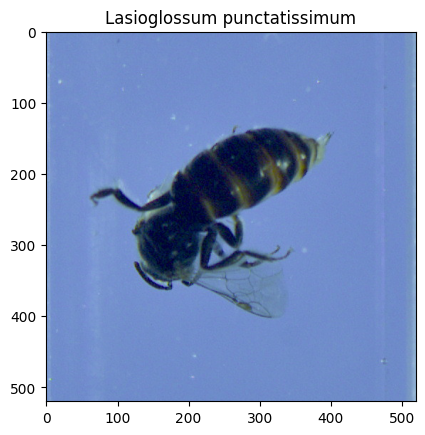

In [136]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4


# Set up the dataset.
dataset = CustomImageDataset('data/assignment1-insects/insects.csv', 'data/assignment1-insects/Insects')
#Create indices for the dataset, to allow for splitting into training, validation and test sets with pytorch.
indices = list(range(len(dataset)))



train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42) #70% training, 30% to be split below
valid_indices, test_inddices = train_test_split(temp_indices, test_size=0.5, random_state=42) #15% validation, 15% test

#Create subsets of the data using the split indices
train_data = torch.utils.data.Subset(dataset, train_indices)
valid_data = torch.utils.data.Subset(dataset, valid_indices)
test_data = torch.utils.data.Subset(dataset, test_inddices)

# Create the dataloaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# get some images
dataiter = iter(trainloader)
images, labels = next(dataiter)


for i in range(5): #Run through 5 bathes
    images, labels = next(dataiter)
    for image, label in zip(images,labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.title(label)

# Part 3
**a: describe & visualize the data**

            labels     feature1     feature2
count  1200.000000  1200.000000  1200.000000
mean      2.001667    -0.005118    -0.011813
std       1.423617     0.406383     0.407423
min       0.000000    -0.991967    -0.940022
25%       1.000000    -0.252324    -0.252466
50%       2.000000     0.000000    -0.011340
75%       3.000000     0.244759     0.252078
max       4.000000     0.963337     0.999714
5


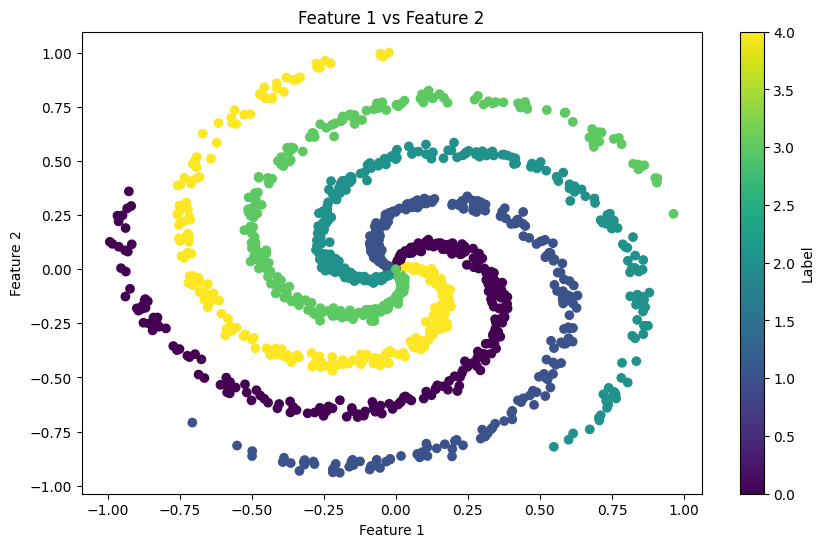

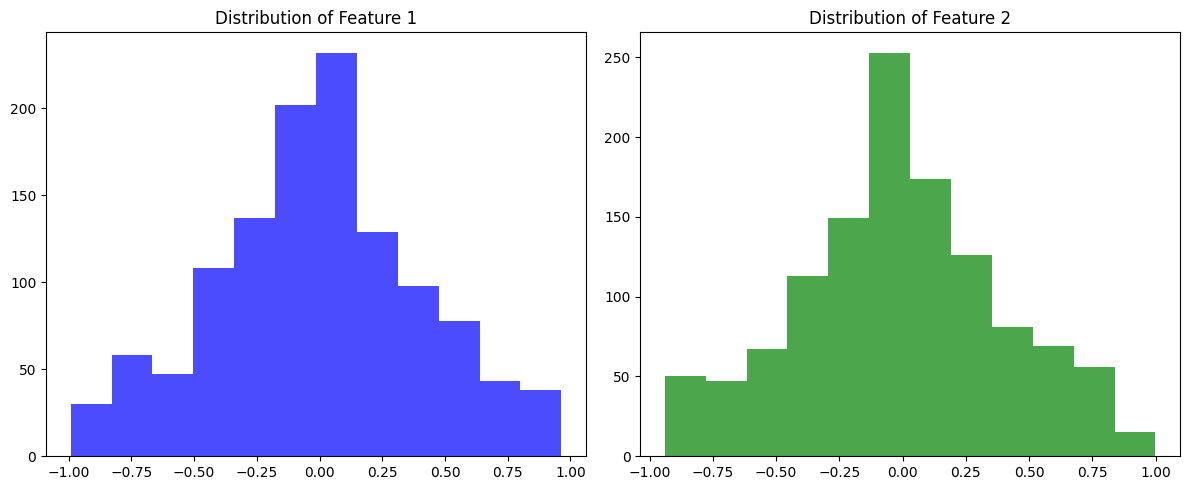

c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

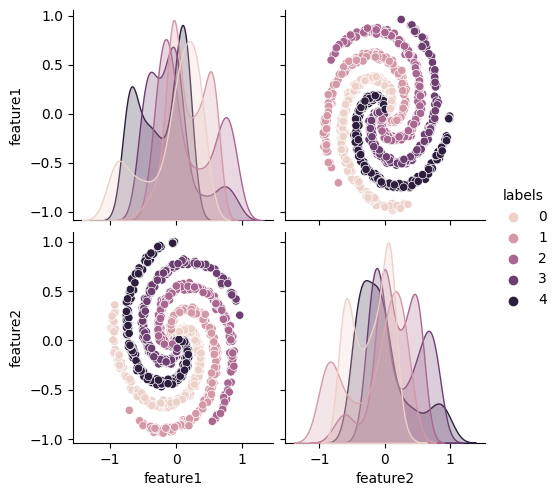

Correlation between Feature 1 and Feature 2: -0.01


In [251]:
#To describe the dataset, we can see some basic statistics about the features and labels by using pandas.describe() functionality
#Read the data
X = pd.read_csv('data/assignment1-insects/assignment1_traindata.csv')
X_test = pd.read_csv('data/assignment1-insects/assignment1_testdata.csv')
print(X.describe())

#Furthermore, we I found it relevant to know how many unique labels there are in the dataset
unique_labels = X['labels'].nunique() #number of unique labels
print(unique_labels)

#To visualize the data we can plot the dataset in different ways, I will try and see what information we can get from a scatterplot, or a histogram first.

#Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(X['feature1'], X['feature2'], c=X['labels'], cmap='viridis')  # Color points by label
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Feature 1 vs Feature 2')
plt.colorbar().set_label('Label')
plt.show()

#Histogram to help show distribution of the data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X['feature1'], bins=12, color='blue', alpha=0.7) #Chose bin size 12, meaning if the data was uniformly distributed, each bin would have 100 samples
plt.title('Distribution of Feature 1')

plt.subplot(1, 2, 2)
plt.hist(X['feature2'], bins=12, color='green', alpha=0.7)
plt.title('Distribution of Feature 2')

plt.tight_layout()
plt.show()

#For more advanced visualization, we can use the seaborn library
#This pairplot will give us the pairwise relationships in the dataset, and color the points by label
#It is visually pleasing, but does not show much more than the prior two together. It does show the distribution of each individual label for the histograms though, which is pretty nice
sns.pairplot(X, hue='labels')
plt.show()

#Lastly, pandas is able to do correlation analysis rather easily, which can help us see if there is any correlation between the features
correlation = X['feature1'].corr(X['feature2'])
print(f'Correlation between Feature 1 and Feature 2: {correlation:.2f}') #Correlation is -0.01, meaning there is no correlation between the features

**b: design a neural network using pytorch to correctly assign labels**

In [252]:
#Lets define our net like we've been learning in the lab sessions:
class Net(nn.Module):
    def __init__(self):
        #Tried the network with only 2 layers where the 2nd just had 5 neurons, but it had a performance of around 75%, so i tried adding an extra hidden layer, which seemed to do the trick
        super(Net, self).__init__()
        self.FC1 = nn.Linear(2, 64) #Input layer, 2 features, 64 neurons
        self.FC2 = nn.Linear(64, 64) #Hidden layer, 64 neurons
        self.FC3 = nn.Linear(64, 5) #Output layer, 5 neurons, one for each label
        
        self.relu = nn.ReLU() #Activation function
        
    def forward(self, x):
        x = self.FC1(x)
        x = self.relu(x)
        
        x = self.FC2(x)
        x = self.relu(x)
        
        x = self.FC3(x)
        
        return x

model = Net()    
model.to(device)


Net(
  (FC1): Linear(in_features=2, out_features=64, bias=True)
  (FC2): Linear(in_features=64, out_features=64, bias=True)
  (FC3): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)

In [253]:
#Defining the inputs and targets, creating the dataset
inputs = torch.tensor((X['feature1'], X['feature2']), dtype=torch.float32).transpose(0,1).to(device)
targets = torch.tensor(X['labels'], dtype=torch.int64).to(device)
dataset = torch.utils.data.TensorDataset(inputs, targets)
indices = list(range(len(dataset)))

#Batch size, just took 4 from part 2, and seemed to be enough, so didnt change it
batch_size = 4

#Splitting the dataset into training, validation and test sets
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42) #70% training, 30% to be split below
valid_indices, test_inddices = train_test_split(temp_indices, test_size=0.5, random_state=42) #15% validation, 15% test


#Create subsets of the data using the split indices
train_data = torch.utils.data.Subset(dataset, train_indices)
valid_data = torch.utils.data.Subset(dataset, valid_indices)
test_data = torch.utils.data.Subset(dataset, test_inddices)

# Create the dataloaders
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
#Loss function and optimizer, again, nothing fancy, just what we've been working with in the lab sessions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model.FC1.weight.dtype)


torch.float32


In [254]:
#Modified the accuracy function from Lab4_2 a tiny bit
def accuracy(scores, labels):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == labels).float().mean()

In [255]:
#This training loop implementation is based on the one from Lab4_2_CNN_batchnorm_dropout_Optimizers.ipynb and adapted to fit my code
epochs = 20
# For book keeping 
train_loss_history = []
valid_loss_history = []
plot_time_train = []
plot_time_valid = []
t = 1

#Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_dl:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels.to(device))
        
        # Book keeping
        train_loss_history.append(loss.detach().cpu().numpy())
        plot_time_train.append(t)
        t += 1
        
        loss.backward()
        
        optimizer.step()

        # Validation loss and accuracy
        if t % 240 == 0:    # print once per epoch (240 batches with batch size 4)
            model.eval() # Test mode
            with torch.no_grad():
                valid_acc = sum(accuracy(model(inputs.to(device)), labels.to(device)) for inputs, labels in valid_dl) / len(valid_dl)
                valid_loss = sum(criterion(model(inputs.to(device)), labels.to(device)) for inputs, labels in valid_dl) / len(valid_dl)
                valid_loss_history.append(valid_loss)
                plot_time_valid.append(t-1)
                print('t',t,'lr',optimizer.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
            model.train() # Back to train mode
        
        
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print("Finished Training")

t 240 lr 0.001 train loss 1.5851221 val loss 1.381545 val accuracy 0.3416667
Epoch 1, Loss: 0.0
t 480 lr 0.001 train loss 1.5635887 val loss 1.1643043 val accuracy 0.4416667
Epoch 2, Loss: 0.0
t 720 lr 0.001 train loss 0.9328394 val loss 0.944046 val accuracy 0.5833334
Epoch 3, Loss: 0.0
t 960 lr 0.001 train loss 0.5129806 val loss 0.7400519 val accuracy 0.7916667
Epoch 4, Loss: 0.0
t 1200 lr 0.001 train loss 0.59208775 val loss 0.5569536 val accuracy 0.85833335
Epoch 5, Loss: 0.0
t 1440 lr 0.001 train loss 0.5302203 val loss 0.45381495 val accuracy 0.85833335
Epoch 6, Loss: 0.0
t 1680 lr 0.001 train loss 0.16559792 val loss 0.3826485 val accuracy 0.86666673
Epoch 7, Loss: 0.0
t 1920 lr 0.001 train loss 0.48499036 val loss 0.32223883 val accuracy 0.8833334
Epoch 8, Loss: 0.0
t 2160 lr 0.001 train loss 0.13374937 val loss 0.26354498 val accuracy 0.8833334
Epoch 9, Loss: 0.0
t 2400 lr 0.001 train loss 0.31793004 val loss 0.2320244 val accuracy 0.9333334
Epoch 10, Loss: 0.0
t 2640 lr 0.00

In [256]:
#set the model to evaluation mode for the test set
model.eval()

#Correct predictions
correct = 0
total = 0
# We dont need to compute gradients for our test, so we can use torch.no_grad()
with torch.no_grad():
    for inputs, labels in test_dl:
        labels = labels.to(device)
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')

Accuracy on test data: 99.17%


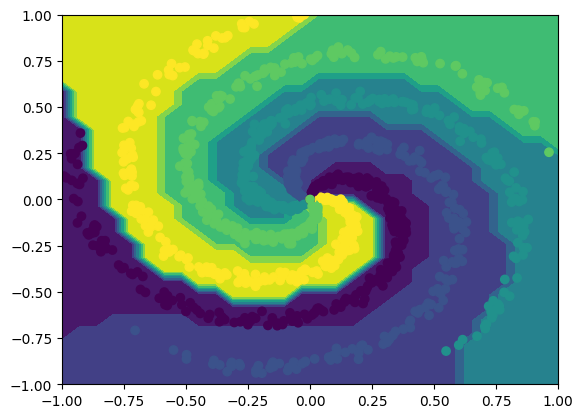

In [257]:
#Inserted visualization as requested. Draws the decision boundaries between labels, combined with the scatterplot I showed earlier.
x,y=np.meshgrid(np.linspace(-1,1,30),np.linspace(-1,1,30))
xy=np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
xy_tensor = torch.tensor(xy).float().to(device)
z=model(xy_tensor).detach().cpu().numpy()
z=np.argmax(z,1).reshape(30,30)
plt.contourf(x,y,z)
plt.scatter(X['feature1'],X['feature2'],c=X['labels'])